In [1]:
import numpy as np 
import pandas as pd
from collections import defaultdict 
import matplotlib.pyplot as plt
import matplotlib 
from scipy.stats import t, f
from sklearn.linear_model import LinearRegression
import scipy as sc

font = {'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

rng = np.random.default_rng(seed=12)

import pyoperon

In [2]:
df = pd.read_csv("grade.csv")
xcols = ['ETA_mean', 'hoursWork_mean', 'numAttendence_max', 'age', 'numChildren', 'enrollmentTime', 'isSingle']

x, y = df[xcols].values, df.grade.values
x = np.concatenate((np.ones((x.shape[0],1)),x), axis=1)

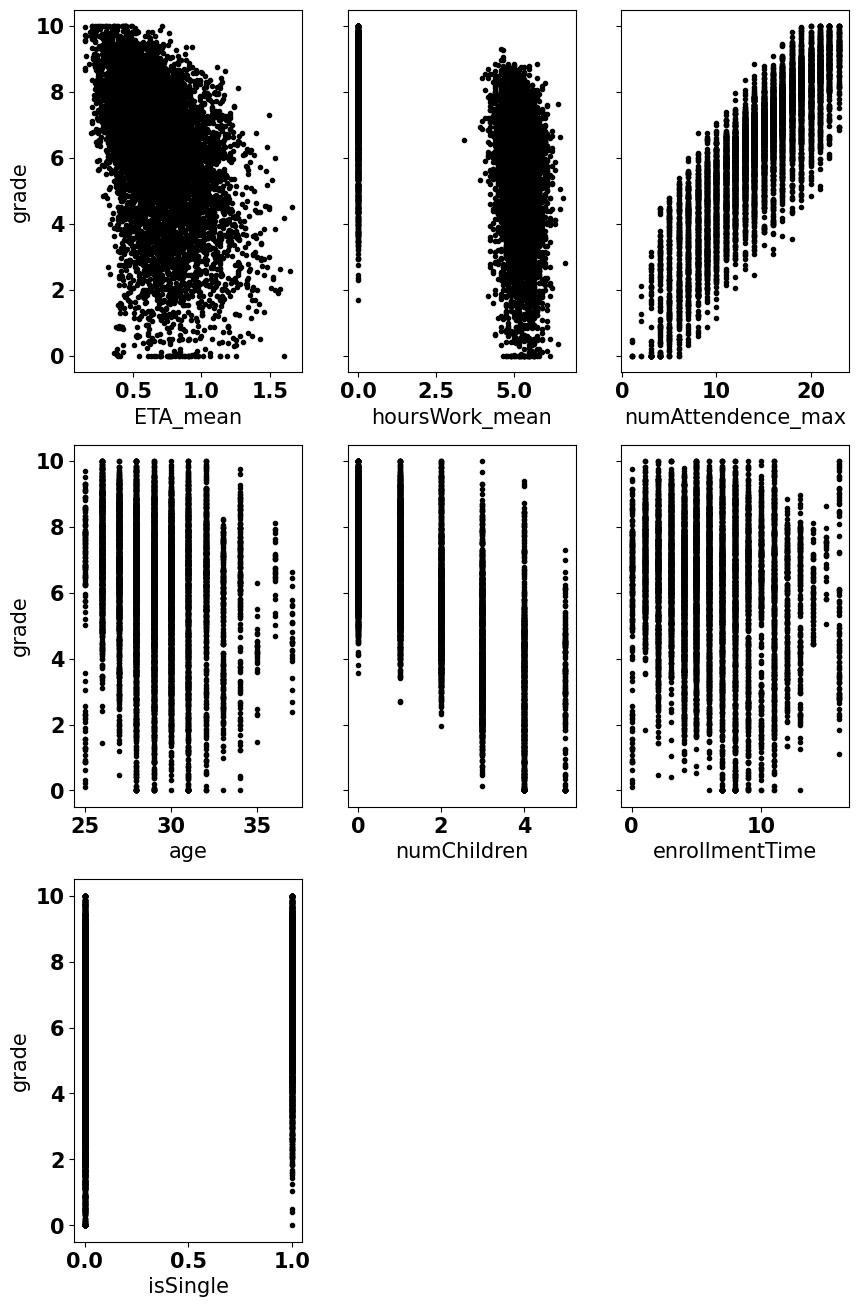

In [3]:
_,axs = plt.subplots(3,3, figsize=(10,16), sharey=True)
ix = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(df[xcols[ix]].values, df.grade.values, '.', color='black')
        axs[i,j].set_xlabel(xcols[ix])
        if j==0:
            axs[i,j].set_ylabel('grade')
        ix = ix+1
axs[2,0].plot(df[xcols[ix]].values, df.grade.values, '.', color='black')
axs[2,0].set_xlabel(xcols[ix])
axs[2,0].set_ylabel('grade')
axs[2,1].axis('off')
axs[2,2].axis('off')
plt.savefig("../figs/eda_predictors.png", bbox_inches='tight')

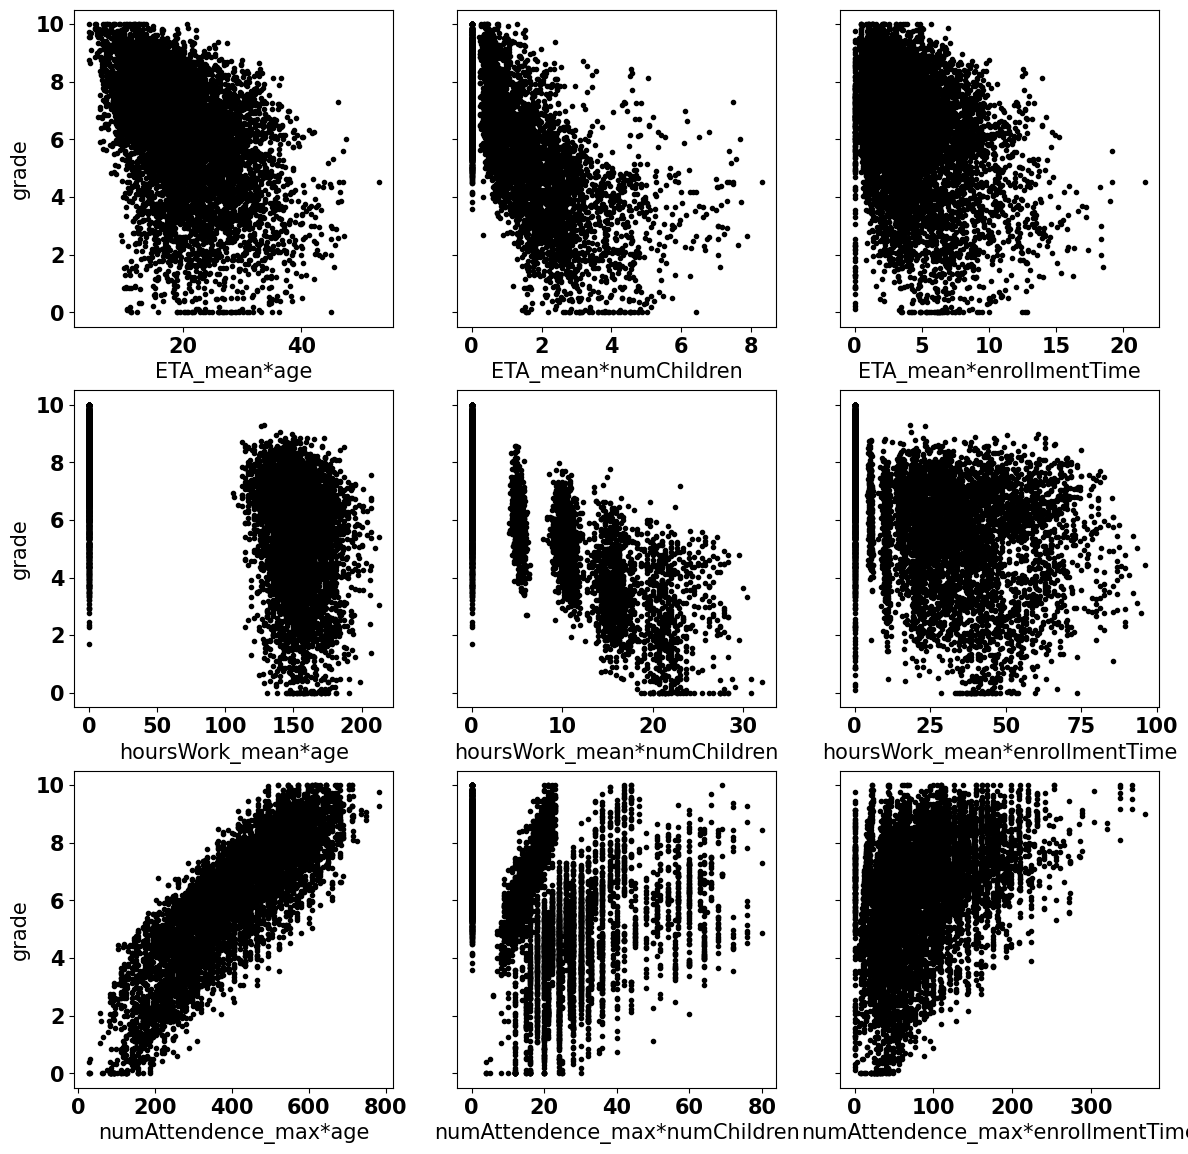

In [4]:
_,axs = plt.subplots(3,3, figsize=(14,14), sharey=True)
ix = 0
for i, c1 in enumerate(xcols[:3]):
    for j, c2 in enumerate(xcols[3:6]):
        axs[i,j].plot(df[c1].values*df[c2].values, df.grade.values, '.', color='black')
        axs[i,j].set_xlabel(f"{c1}*{c2}")
        if j==0:
            axs[i,j].set_ylabel('grade')
        ix = ix+1
plt.savefig("../figs/eda_interactions.png", bbox_inches='tight')        

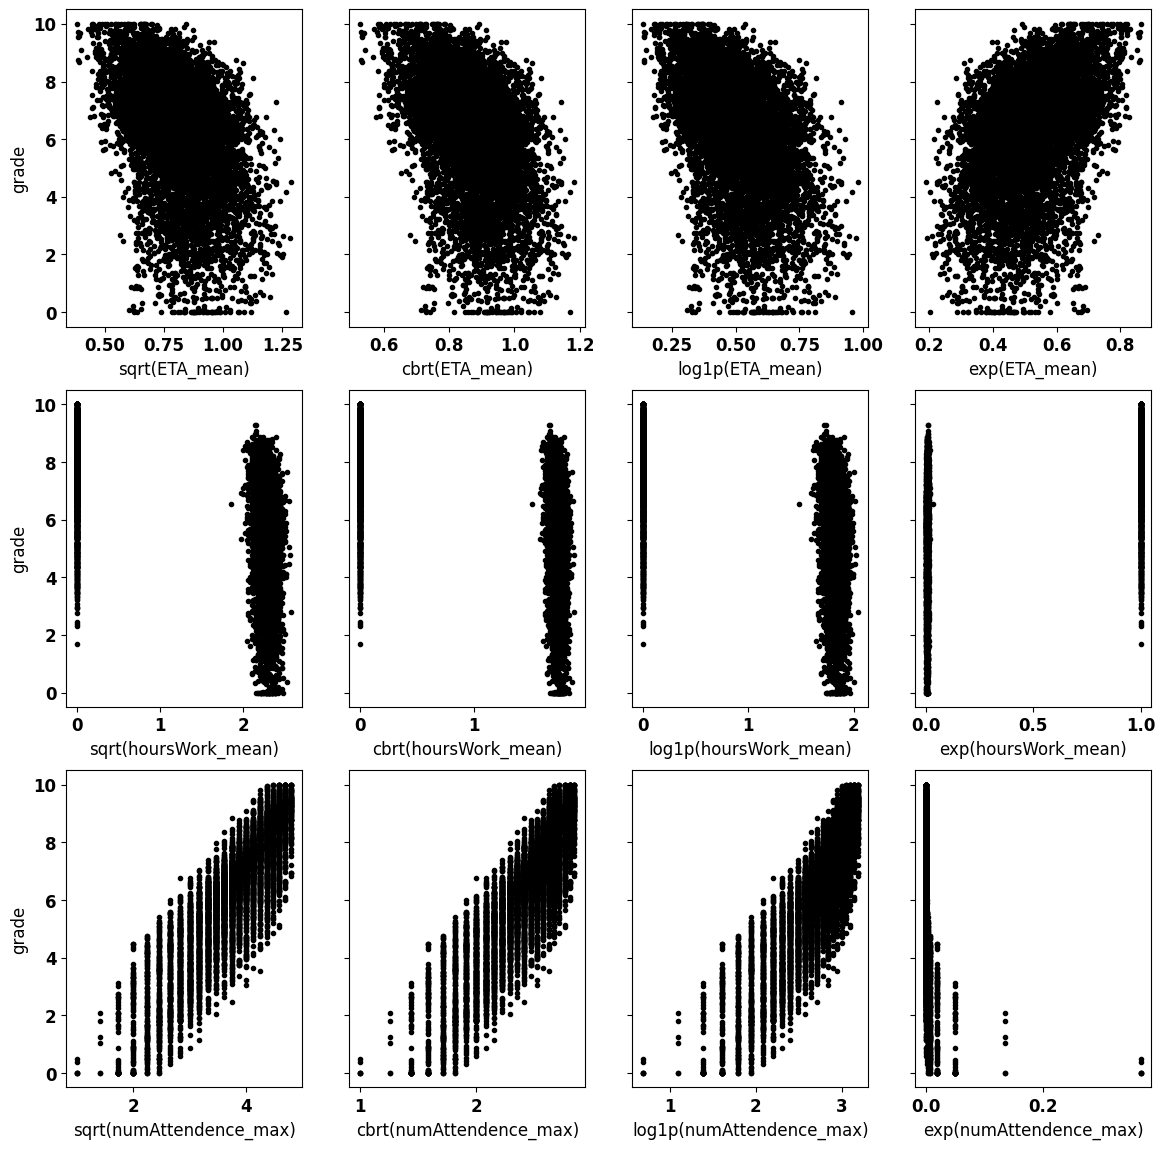

In [5]:
font = {'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

_,axs = plt.subplots(3,4, figsize=(14,14), sharey=True)
ix = 0
for i, c1 in enumerate(xcols[:3]):
    for j, (fname,h) in enumerate([('sqrt',np.sqrt), ('cbrt', np.cbrt), ('log1p', np.log1p), ('exp', lambda x: np.exp(-x))]):
        axs[i,j].plot(h(df[c1].values), df.grade.values, '.', color='black')
        axs[i,j].set_xlabel(f"{fname}({c1})")
        if j==0:
            axs[i,j].set_ylabel('grade')
        ix = ix+1
plt.savefig("../figs/eda_transformations.png", bbox_inches='tight')        

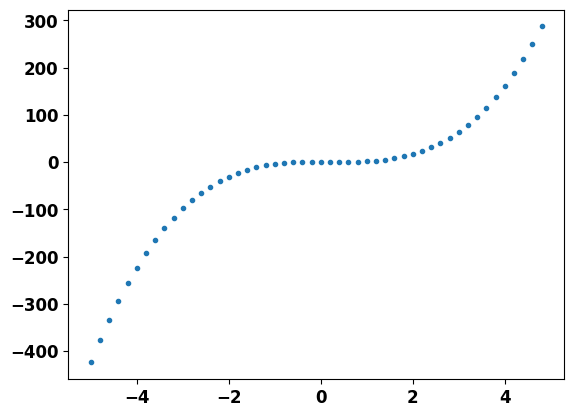

In [6]:
x = np.arange(-5, 5, 0.2)
y = rng.normal( 3*x**3 - 2*x**2 + 0.1*x + 1, 0.2)
plt.plot(x, y, '.')

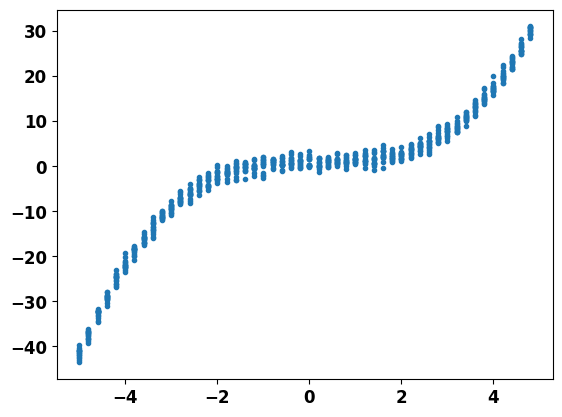

In [7]:
x = np.repeat(np.arange(-5, 5, 0.2), 15)
y = rng.normal( 0.3*x**3 - 0.2*x**2 + 0.1*x + 1, 1)
plt.plot(x, y, '.')
plt.savefig("../figs/cubic.png", bbox_inches='tight')

In [9]:
from pyoperon.sklearn import SymbolicRegressor
from sklearn.linear_model import LinearRegression
import sympy as sym
from sympy import Number 

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})
    
lin = LinearRegression()
lin.fit(x.reshape(-1,1), y)
print("LR: ", lin.score(x.reshape(-1,1), y))
print(f"{lin.coef_}*x")

xpoly = np.vstack([x, x**2, x**3]).T
lin.fit(xpoly,y)
print("Poly: ", lin.score(xpoly, y))
print(f"{lin.coef_}")
print("====================")

reg = SymbolicRegressor()
reg.fit(x.reshape(-1,1),y)
res = [(s['objective_values'], s['tree'], s['minimum_description_length']) for s in reg.pareto_front_]

for obj, expr, mdl in res:
    print("Score: ", obj)
    print("Expr: ", reg.get_model_string(expr, 3))
    print("Simplified: ", round_expr(sym.simplify(sym.sympify(reg.get_model_string(expr, 3))),2))
print("====================")

reg = SymbolicRegressor(max_length=20, allowed_symbols= "add,mul,variable")
reg.fit(x.reshape(-1,1),y)
res = [(s['objective_values'], s['tree'], s['minimum_description_length']) for s in reg.pareto_front_]

for obj, expr, mdl in res:
    print("Score: ", obj)
    print("Expr: ", reg.get_model_string(expr, 3))
    print("Simplified: ",  round_expr(sym.simplify(sym.sympify(reg.get_model_string(expr, 3))),2))
print("====================")

reg = SymbolicRegressor(objectives=['r2', 'length'])
reg.fit(x.reshape(-1,1),y)
res = [(s['objective_values'], s['tree'], s['minimum_description_length']) for s in reg.pareto_front_]

for obj, expr, mdl in res:
    print("Score: ", obj)
    print("Expr: ", reg.get_model_string(expr, 3))
    print("Simplified: ",  round_expr(sym.simplify(sym.sympify(reg.get_model_string(expr, 3))),2))
print("====================")    

LR:  0.8270264818337354
[4.63666261]*x
Poly:  0.9954350189137037
[ 0.10778345 -0.20262076  0.29890484]
Score:  [-0.9955134987831116]
Expr:  (1.013 + ((-0.026) * ((((((-2.050) * X1) * (((-0.041) + (1.198 * X1)) * ((-1.467) + (2.303 * X1)))) - (((-0.001) * X1) - ((-1.853) * X1))) / 0.499) - (((-1.456) - ((((-1.467) + ((-0.041) + (1.264 * X1))) + (2.303 * X1)) / (((-2.553) - ((-1.569) * X1)) - (((-0.041) - (-0.041)) - ((1.198 * X1) * (1.198 * X1)))))) / ((((-2.050) * X1) - (0.693 * X1)) - (((-0.250) - 0.345) - ((1.198 * X1) * (1.198 * X1))))))))
Simplified:  (0.61*X1**7 - 0.9*X1**6 - 1.55*X1**5 + 5.66*X1**4 - 4.46*X1**3 - 6.14*X1**2 + 7.73*X1 - 1.4)/(2.06*X1**4 - 1.68*X1**3 - 7.11*X1**2 + 7.94*X1 - 1.52)
Score:  [-0.9954407215118408]
Expr:  (1.043 + ((-0.156) * ((((-1.906) * X1) * ((((-0.012) * X1) * (0.693 * X1)) * ((0.138 * X1) * (0.693 * X1)))) + (((-0.496) * X1) + (((-1.910) * X1) * ((((-0.611) * X1) * ((-1.678) * X1)) + ((-0.685) * X1)))))))
Simplified:  X1**2*(0.31*X1 - 0.2) + 0.08*

In [11]:
from pyTIR import TIRRegressor

reg = TIRRegressor(100, 100, 0.3, 0.7, (-3, 3), transfunctions='Id', alg='MOO')
reg.fit(x.reshape(-1,1), y)
for e in reg.front:
    try:
        ex, _, sc = e.split(";")
        print(sc)
        print(round_expr(sym.simplify(sym.sympify(ex.replace("[:,","").replace("]","").replace("np.",""))),2))
    except:
        pass

[0.9937675615949605,20.0]
0.3*x0**3 - 0.2*x0**2 + 0.1*x0 + 1.06
[0.992757244463969,52.0]
(0.3*x0**3 - 0.15*x0**2 + 0.1*x0 + 0.99)/(0.02*x0 + 1.0)
[0.993767561594961,20.0]
0.3*x0**3 - 0.2*x0**2 + 0.1*x0 + 1.06
[0.9937675615949594,26.0]
0.3*x0**3 - 0.2*x0**2 + 0.1*x0 + 1.06
[0.9927572444639713,40.0]
(0.3*x0**3 - 0.15*x0**2 + 0.1*x0 + 0.99)/(0.02*x0 + 1.0)
[0.9927572444639695,46.0]
(0.3*x0**3 - 0.15*x0**2 + 0.1*x0 + 0.99)/(0.02*x0 + 1.0)
[0.9936567966356317,32.0]
0.3*x0**3 - 0.2*x0**2 + 0.1*x0 + 1.06
[0.9927572444640015,34.0]
(0.3*x0**3 - 0.15*x0**2 + 0.1*x0 + 0.99)/(0.02*x0 + 1.0)
[0.9927572444639685,20.0]
(0.3*x0**3 - 0.15*x0**2 + 0.1*x0 + 0.99)/(0.02*x0 + 1.0)
[0.9925126297876246,52.0]
(0.3*x0**3 - 0.16*x0**2 + 0.09*x0 + 1.01)/(0.02*x0 + 1.0)
[0.9927572444640023,0.0]
(0.3*x0**3 - 0.15*x0**2 + 0.1*x0 + 0.99)/(0.02*x0 + 1.0)
[0.9926493627769779,40.0]
(0.3*x0**3 - 0.16*x0**2 + 0.09*x0 + 1.01)/(0.02*x0 + 1.0)
[0.9925372864690137,46.0]
(0.3*x0**3 - 0.16*x0**2 + 0.09*x0 + 1.01)/(0.02*x0 + 1.

In [12]:
from pysr import PySRRegressor

reg = PySRRegressor(binary_operators=["+", "*"], unary_operators=[])
reg.fit(x.reshape(-1,1), y)
print(reg)

/home/olivetti/.local/pyenv/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...
Started!
PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x0   
	1        0.679668                                   (x0 * 4.6480193)   
	2        0.011897                     ((x0 * 4.636663) + -0.9502593)   
	3        1.164961                    ((x0 * (0.30941126 * x0)) * x0)   
	4  >>>>  0.453127     (((x0 * 0.3057221) * x0) * (x0 + -0.43361983))   
	5        0.191506  ((((0.30495232 * x0) * x0) * (x0 + -0.66016245...   
	6        0.003884  (((((((x0 * 0.29890487) + -0.20262024) * x0) +...   
	
	         loss  complexity  
	0  149.348790           1  
	1   38.357426           3  
	2   37.455544           5  
	3    3.644550           7  
	4    1.472524           9  
	5    1.003975          11  
	6    0.988497          15  
]


In [14]:
for e in reg.equations_.sympy_format.values:
    print(round_expr(sym.simplify(sym.sympify(e)),2))

x0
4.65*x0
4.64*x0 - 0.95
0.31*x0**3
x0**2*(0.31*x0 - 0.13)
x0**2*(0.3*x0 - 0.2) + 1.03
x0*(x0*(0.3*x0 - 0.2) - 0.89) + x0 + 1.03
